In [1]:
#  Import modules
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import os
from scipy.stats import multivariate_normal

In [2]:
# Configurations
FILES = ['EMGaussian.train', 'EMGaussian.test']

NUM_MEANS = 4
NUM_ITER = 30
NUM_ITER_EM = 100

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
#  Load training data
test = tf.placeholder(dtype=tf.float32, shape=[None, 2])
train = tf.placeholder(dtype=tf.float32, shape=[None, 2])

train_data = pd.read_table('hwk3data/' + FILES[0], header=None, sep=' ')
test_data = pd.read_table('hwk3data/' + FILES[1], header=None, sep=' ')
n = train_data.shape[0] # Train and test data same size

In [4]:
#  KMeans TF ops and Vars
cluster_centers = tf.Variable(initial_value=tf.random_uniform(shape=[1, 2, NUM_MEANS],minval=-4, maxval=4),
                              dtype=tf.float32, validate_shape=False)
hidden = tf.Variable(initial_value=tf.random_uniform(shape=[n], minval=0, maxval=4, dtype=tf.int64))
loss = tf.Variable(0, dtype=tf.float32)

#  Compute distortion measure!
distortion_measure = tf.reduce_sum(tf.squared_difference(tf.expand_dims(train, 2), cluster_centers), axis=1)

#  Assign clusters based on distortion
hidden_op = hidden.assign(tf.argmin(distortion_measure, dimension=1))

#  Compute loss
loss_op = loss.assign(tf.reduce_mean(tf.reduce_min(distortion_measure, axis=1)))

#  Assign cluster
cluster_op = cluster_centers.assign([tf.transpose([tf.reduce_mean(
    tf.squeeze(tf.gather(train, indices=tf.where(condition=tf.equal(hidden, i)))), axis=0) for i in range(NUM_MEANS)])])

init_op = tf.global_variables_initializer()

In [5]:
#  Run algorithm
centers_list = []
with tf.Session() as sess:
    for j in range(1):
        sess.run(init_op)
        for iter in range(NUM_ITER):
            #  E-Step
            hidden, loss = sess.run([hidden_op, loss_op], feed_dict={train: train_data})
            print("current mean square deviation at iter {0}: {1}".format(iter, loss))
            #  M-Stop
            centers = sess.run([cluster_op], feed_dict={train: train_data})
            centers = np.transpose(centers[0][0])  # Makes it look nice
        centers_list.append(centers)
        #print("current clusters: \n {0}".format(centers))

centers = np.mean(centers_list, axis=0)

current mean square deviation at iter 0: 24.066984176635742
current mean square deviation at iter 1: 12.937790870666504
current mean square deviation at iter 2: 11.302926063537598
current mean square deviation at iter 3: 9.046603202819824
current mean square deviation at iter 4: 7.939294815063477
current mean square deviation at iter 5: 7.317136764526367
current mean square deviation at iter 6: 6.803309440612793
current mean square deviation at iter 7: 6.532477378845215
current mean square deviation at iter 8: 6.4860711097717285
current mean square deviation at iter 9: 6.48256254196167
current mean square deviation at iter 10: 6.478429794311523
current mean square deviation at iter 11: 6.476276397705078
current mean square deviation at iter 12: 6.476276397705078
current mean square deviation at iter 13: 6.476276397705078
current mean square deviation at iter 14: 6.476276397705078
current mean square deviation at iter 15: 6.476276397705078
current mean square deviation at iter 16: 6.476

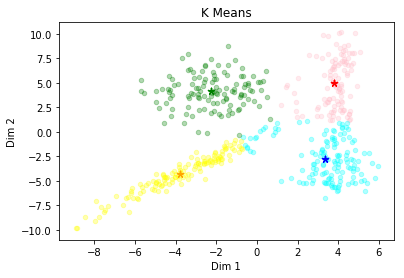

In [6]:
#  Plot data points and seperating plane
plt.figure()
plt.scatter(x=train_data[hidden==0][0], y=train_data[hidden==0][1], color='pink', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden==1][0], y=train_data[hidden==1][1], color='cyan', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden==2][0], y=train_data[hidden==2][1], color='green', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden==3][0], y=train_data[hidden==3][1], color='yellow', alpha=0.3, s=20)
plt.scatter(x=centers[0][0], y=centers[0][1], color='red', marker=(5, 2), s=40)
plt.scatter(x=centers[1][0], y=centers[1][1], color='blue', marker=(5, 2), s=40)
plt.scatter(x=centers[2][0], y=centers[2][1], color='green', marker=(5, 2), s=40)
plt.scatter(x=centers[3][0], y=centers[3][1], color='orange', marker=(5, 2), s=40)


plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('K Means')

#plt.savefig('../K_means_img')
plt.show()

In [7]:
#  EM

#  Initialize variables
pi = [hidden.tolist().count(i)/len(hidden) for i in range(NUM_MEANS)]
pi_list = [pi]

mu = centers
mu_list = [mu]

sigmas = [np.sum(((train_data[hidden==i][0]-mu[i][0])**2 + (train_data[hidden==i][1]-mu[i][1])**2))
                  /hidden.tolist().count(i) for i in range(NUM_MEANS)]

covariance = [[[s,0], [0,s]] for s in sigmas]
cov_list = [covariance]

In [8]:
losses = []
for iter_em in range(NUM_ITER_EM):
    pi = pi_list[iter_em]
    mu = mu_list[iter_em]
    covariance = cov_list[iter_em]

    # E Step
    responsibilities = np.transpose([pi[i]*multivariate_normal(mean=mu[i], cov=covariance[i]).pdf(train_data)
                                     for i in range(NUM_MEANS)])

    #  normalize
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=1)

    # M Step
    new_pi = responsibilities.mean(axis=0)
    new_mu = np.dot(np.transpose(responsibilities), train_data) / \
             np.transpose([responsibilities.sum(axis=0), responsibilities.sum(axis=0)])

    new_covariance = []
    avg_X2 = np.dot(responsibilities.T, train_data * train_data)/np.sum(responsibilities, axis=0)[:, np.newaxis]
    avg_means2 = mu ** 2
    avg_X_means = mu * np.dot(responsibilities.T, train_data) / np.sum(responsibilities, axis=0)[:, np.newaxis]
    t = (avg_X2 - 2 * avg_X_means + avg_means2).mean(1)

    new_covariance.append([[t[0], 0], [0,t[0]]])
    new_covariance.append([[t[1], 0], [0,t[1]]])
    new_covariance.append([[t[2], 0], [0,t[2]]])
    new_covariance.append([[t[3], 0], [0,t[3]]])

    # Compute loss
    loss = np.sum([pi[i]*multivariate_normal(mean=mu[i], cov=new_covariance[i]).pdf(train_data)
                   for i in range(NUM_MEANS)], axis=0)
    loss = np.mean(np.log(loss))
    losses.append(loss)

    mu_list.append(new_mu)
    cov_list.append(new_covariance)
    pi_list.append(new_pi)

    print('log likelihood for iteration {0}: {1}'.format(iter_em, loss))

log likelihood for iteration 0: -5.331273762806823
log likelihood for iteration 1: -5.314155111229349
log likelihood for iteration 2: -5.307524709052308
log likelihood for iteration 3: -5.30615755313301
log likelihood for iteration 4: -5.305706243696639
log likelihood for iteration 5: -5.305449515555834
log likelihood for iteration 6: -5.30522512109801
log likelihood for iteration 7: -5.304989249339486
log likelihood for iteration 8: -5.304729098376811
log likelihood for iteration 9: -5.304440666498238
log likelihood for iteration 10: -5.304122962019253
log likelihood for iteration 11: -5.303776392852047
log likelihood for iteration 12: -5.303402249990122
log likelihood for iteration 13: -5.303002475983269
log likelihood for iteration 14: -5.302579501318582
log likelihood for iteration 15: -5.302136096845977
log likelihood for iteration 16: -5.301675237755005
log likelihood for iteration 17: -5.301199986371615
log likelihood for iteration 18: -5.300713401214085
log likelihood for itera

In [9]:
# Get final params
mu = mu_list[-1]
covariance = cov_list[-1]
pi = pi_list[-1]
loss = losses[-1]
print("mean of clusters: {}".format(mu))
print("mixing props of clusters: {}".format(pi))
print("covariances of clusters: {}".format(covariance))

mean of clusters: [[ 3.9672377   6.7002121 ]
 [ 2.45007631 -1.44535184]
 [-2.25977437  4.33300249]
 [-4.47774973 -4.91780653]]
mixing props of clusters: [ 0.13314475  0.45374908  0.22175697  0.1913492 ]
covariances of clusters: [[[1.6475493801941639, 0], [0, 1.6475493801941639]], [[6.5635740110459011, 0], [0, 6.5635740110459011]], [[2.3587054454751812, 0], [0, 2.3587054454751812]], [[3.1847977236220739, 0], [0, 3.1847977236220739]]]


In [10]:
test_loss = np.sum([pi[i]*multivariate_normal(mean=mu[i], cov=covariance[i]).pdf(test_data)
                   for i in range(NUM_MEANS)], axis=0)
test_loss = np.mean(np.log(test_loss))
print("train loss: {}".format(loss))
print("test loss: {}".format(test_loss))

train loss: -5.29104865241881
test loss: -5.3881677806041095


In [ ]:
#  Plot data points and seperating plane
hidden2 = np.argmax(responsibilities, axis=1) # Get cluster assignments for plots
plt.figure()
plt.scatter(x=train_data[hidden2==0][0], y=train_data[hidden2==0][1], color='pink', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden2==1][0], y=train_data[hidden2==1][1], color='cyan', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden2==2][0], y=train_data[hidden2==2][1], color='green', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden2==3][0], y=train_data[hidden2==3][1], color='yellow', alpha=0.3, s=20)
plt.scatter(x=mu[0][0], y=mu[0][1], color='red', marker=(5, 2), s=40)
plt.scatter(x=mu[1][0], y=mu[1][1], color='blue', marker=(5, 2), s=40)
plt.scatter(x=mu[2][0], y=mu[2][1], color='green', marker=(5, 2), s=40)
plt.scatter(x=mu[3][0], y=mu[3][1], color='orange', marker=(5, 2), s=40)

#  Overlay with contours of Normal Dist.
x = np.linspace(-10, 10)
y = np.linspace(-10, 10)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=covariance[0][0][0], sigmay=covariance[0][1][1],
                           mux=mu[0][0], muy=mu[0][1], sigmaxy=covariance[0][0][1])
Z2 = mlab.bivariate_normal(X, Y, sigmax=covariance[1][0][0], sigmay=covariance[1][1][1],
                           mux=mu[1][0], muy=mu[1][1], sigmaxy=covariance[1][0][1])
Z3 = mlab.bivariate_normal(X, Y, sigmax=covariance[2][0][0], sigmay=covariance[2][1][1],
                           mux=mu[2][0], muy=mu[2][1], sigmaxy=covariance[2][0][1])
Z4 = mlab.bivariate_normal(X, Y, sigmax=covariance[3][0][0], sigmay=covariance[3][1][1],
                           mux=mu[3][0], muy=mu[3][1], sigmaxy=covariance[3][0][1])
plt.contour(X, Y, Z1, colors='red')
plt.contour(X, Y, Z2, colors='blue')
plt.contour(X, Y, Z3, colors='green')
plt.contour(X, Y, Z4, colors='orange')


plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('EM With Spherical Covariance')

#plt.savefig('../EM_Spherical_img')
plt.show()

In [11]:
#  General EM

#  Initialize variables
pi = [hidden.tolist().count(i)/len(hidden) for i in range(NUM_MEANS)]
pi_list = [pi]

mu = centers
mu_list = [mu]
sigmas = [np.dot(np.transpose(train_data[hidden==i]-mu[0]),train_data[hidden==i]-mu[0])/hidden.tolist().count(i)
          for i in range(NUM_MEANS)]
cov_list = [sigmas]

In [12]:
losses = []
for iter_em in range(NUM_ITER_EM):
    pi = pi_list[iter_em]
    mu = mu_list[iter_em]
    covariance = cov_list[iter_em]

    # E Step
    responsibilities = np.transpose([pi[i]*multivariate_normal(mean=mu[i], cov=covariance[i]).pdf(train_data)
                                     for i in range(NUM_MEANS)])

    #  normalize
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=1)

    # M Step
    new_pi = responsibilities.mean(axis=0)
    new_mu = np.dot(np.transpose(responsibilities), train_data) / \
             np.transpose([responsibilities.sum(axis=0), responsibilities.sum(axis=0)])

    new_covariance = np.empty((4, 2, 2))
    for k in range(4):
        diff = train_data - mu[k]
        new_covariance[k] = np.dot(responsibilities[:, k] * diff.T, diff) / np.sum(responsibilities, axis=0)[k]
        new_covariance[k].flat[::2 + 1]


    # Compute loss
    loss = np.sum([pi[i]*multivariate_normal(mean=mu[i], cov=covariance[i]).pdf(train_data)
                   for i in range(NUM_MEANS)], axis=0)
    loss = np.mean(np.log(loss))
    losses.append(loss)

    mu_list.append(new_mu)
    cov_list.append(new_covariance)
    pi_list.append(new_pi)

    print('log likelihood for iteration {0}: {1}'.format(iter_em, loss))

log likelihood for iteration 0: -5.469887523345566
log likelihood for iteration 1: -4.773178912613936
log likelihood for iteration 2: -4.695819056506695
log likelihood for iteration 3: -4.683521638587678
log likelihood for iteration 4: -4.677236518542769
log likelihood for iteration 5: -4.67337261026167
log likelihood for iteration 6: -4.670284901170489
log likelihood for iteration 7: -4.667465851268073
log likelihood for iteration 8: -4.664864317310093
log likelihood for iteration 9: -4.662564053760945
log likelihood for iteration 10: -4.660651778171258
log likelihood for iteration 11: -4.6591563499486055
log likelihood for iteration 12: -4.658043833090796
log likelihood for iteration 13: -4.657245058579775
log likelihood for iteration 14: -4.656684408905891
log likelihood for iteration 15: -4.656295942713848
log likelihood for iteration 16: -4.656028417970467
log likelihood for iteration 17: -4.65584449909526
log likelihood for iteration 18: -4.655717949047874
log likelihood for iter

In [13]:
# Get final params and loss
mu = mu_list[-1]
covariance = cov_list[-1]
pi = pi_list[-1]
print("mean of clusters: {}".format(mu))
print("mixing props of clusters: {}".format(pi))
print("covariances of clusters: {}".format(covariance))

test_loss = np.sum([pi[i]*multivariate_normal(mean=mu[i], cov=covariance[i]).pdf(test_data)
                   for i in range(NUM_MEANS)], axis=0)
test_loss = np.mean(np.log(test_loss))

print("train loss: {}".format(loss))
print("test loss: {}".format(test_loss))

mean of clusters: [[ 3.97793026  3.77333073]
 [ 3.80070948 -3.79729738]
 [-2.03436695  4.17258596]
 [-3.06196072 -3.53454048]]
mixing props of clusters: [ 0.25998573  0.18290156  0.25155719  0.30555552]
covariances of clusters: [[[  0.21035666   0.29045082]
  [  0.29045082  12.23996545]]

 [[  0.92127925   0.0573808 ]
  [  0.0573808    1.86586027]]

 [[  2.90442381   0.20655763]
  [  0.20655763   2.75617077]]

 [[  6.24140912   6.05017466]
  [  6.05017466   6.18245531]]]
train loss: -4.6554313498433
test loss: -4.817956307698112


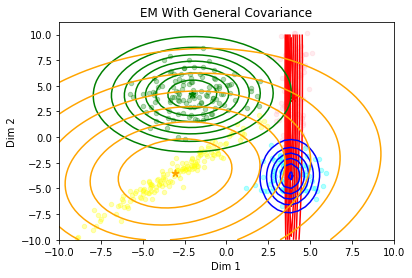

In [14]:
hidden3 = np.argmax(responsibilities, axis=1)
#  Plot data points and seperating plane
plt.figure()
plt.scatter(x=train_data[hidden3==0][0], y=train_data[hidden3==0][1], color='pink', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden3==1][0], y=train_data[hidden3==1][1], color='cyan', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden3==2][0], y=train_data[hidden3==2][1], color='green', alpha=0.3, s=20)
plt.scatter(x=train_data[hidden3==3][0], y=train_data[hidden3==3][1], color='yellow', alpha=0.3, s=20)
plt.scatter(x=mu[0][0], y=mu[0][1], color='red', marker=(5, 2), s=40)
plt.scatter(x=mu[1][0], y=mu[1][1], color='blue', marker=(5, 2), s=40)
plt.scatter(x=mu[2][0], y=mu[2][1], color='green', marker=(5, 2), s=40)
plt.scatter(x=mu[3][0], y=mu[3][1], color='orange', marker=(5, 2), s=40)

#  Overlay with contours of Normal Dist.
x = np.linspace(-10, 10)
y = np.linspace(-10, 10)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=covariance[0][0][0], sigmay=covariance[0][1][1],
                           mux=mu[0][0], muy=mu[0][1], sigmaxy=covariance[0][0][1])
Z2 = mlab.bivariate_normal(X, Y, sigmax=covariance[1][0][0], sigmay=covariance[1][1][1],
                           mux=mu[1][0], muy=mu[1][1], sigmaxy=covariance[1][0][1])
Z3 = mlab.bivariate_normal(X, Y, sigmax=covariance[2][0][0], sigmay=covariance[2][1][1],
                           mux=mu[2][0], muy=mu[2][1], sigmaxy=covariance[2][0][1])
Z4 = mlab.bivariate_normal(X, Y, sigmax=covariance[3][0][0], sigmay=covariance[3][1][1],
                           mux=mu[3][0], muy=mu[3][1], sigmaxy=covariance[3][0][1])
plt.contour(X, Y, Z1, colors='red')
plt.contour(X, Y, Z2, colors='blue')
plt.contour(X, Y, Z3, colors='green')
plt.contour(X, Y, Z4, colors='orange')


plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('EM With General Covariance')

#plt.savefig('../EM_General_img')
plt.show()